<a href="https://colab.research.google.com/github/Mino94/section4-project-DL/blob/main/section4_project_%EA%B9%80%EB%AF%BC%ED%98%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 화이자 백신 Twitter 감정 분류




In [1]:
import os
os.environ['KAGGLE_USERNAME'] = 'mino94' # username
os.environ['KAGGLE_KEY'] = '' # key

In [2]:
!kaggle datasets download -d gpreda/pfizer-vaccine-tweets

pfizer-vaccine-tweets.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
!unzip -q pfizer-vaccine-tweets.zip

replace vaccination_tweets.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


In [4]:
!pip install -q tensorflow-text

In [5]:
!pip install -q tf-models-official

In [6]:
!pwd

/content


In [7]:
import pandas as pd
import numpy as np

raw_df = pd.read_csv('./vaccination_tweets.csv')
raw_df.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"Facts are immutable, Senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,Explain to me again why we need a vaccine @Bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot 스타일과 폰트 크기를 설정합니다.
sns.set(style='whitegrid', font_scale=1.15)

# 문서별 단어의 수 분포도 그리는 함수
def plot_text_length_dist(text_list):

    # 문장이 요소인 리스트를 받아 각 문서의 단어 수를 가진 리스트를 만듭니다
    num_words = [len(doc.split()) for doc in text_list]
    
    sns.displot(num_words)
    plt.title('# of words per documents')
    plt.xlabel('Number of words')
    plt.ylabel('Number of documents')
    plt.show()

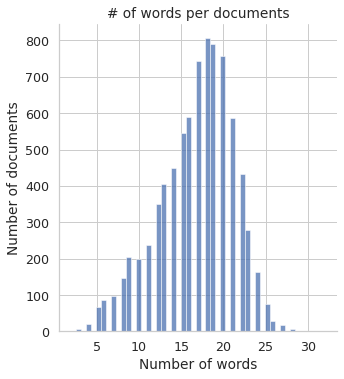

In [9]:
plot_text_length_dist(raw_df['text'])

In [10]:
# Tokenizer
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_sm")

tokenizer = Tokenizer(nlp.vocab)

In [11]:
import re
import sys
raw_df = raw_df[raw_df['text'].notna()]
for idx, text in zip(raw_df.index, raw_df['text']):
    text = text.lower()
    text = re.sub(r'[^a-z0-9 ]', '', text)
    raw_df['hashtags'][idx] = text

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [12]:
raw_df.head(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,Same folks said daikon paste could treat a cyt...,same folks said daikon paste could treat a cyt...,Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,While the world has been on the wrong side of ...,while the world has been on the wrong side of ...,Twitter Web App,1,1,False


In [13]:
df = pd.DataFrame(raw_df[['text', 'hashtags']])
df.head()

,text,hashtags
0,Same folks said daikon paste could treat a cyt...,same folks said daikon paste could treat a cyt...
1,While the world has been on the wrong side of ...,while the world has been on the wrong side of ...
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,coronavirus sputnikv astrazeneca pfizerbiontec...
3,"Facts are immutable, Senator, even when you're...",facts are immutable senator even when youre no...
4,Explain to me again why we need a vaccine @Bor...,explain to me again why we need a vaccine bori...


### 불용어제거

In [14]:
STOP_WORDS = nlp.Defaults.stop_words.union(['\n\n', '\n', 'dose'])

In [15]:
tokens = []

for doc in tokenizer.pipe(df['text']):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS and token.text != ' ':
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
df['tokens'] = tokens

In [16]:
# df = df.drop('stoptokens', axis=1)
df.head()

,text,hashtags,tokens
0,Same folks said daikon paste could treat a cyt...,same folks said daikon paste could treat a cyt...,"[folks, said, daikon, paste, treat, cytokine, ..."
1,While the world has been on the wrong side of ...,while the world has been on the wrong side of ...,"[world, wrong, history, year,, hopefully,, big..."
2,#coronavirus #SputnikV #AstraZeneca #PfizerBio...,coronavirus sputnikv astrazeneca pfizerbiontec...,"[#coronavirus, #sputnikv, #astrazeneca, #pfize..."
3,"Facts are immutable, Senator, even when you're...",facts are immutable senator even when youre no...,"[facts, immutable,, senator,, you're, ethicall..."
4,Explain to me again why we need a vaccine @Bor...,explain to me again why we need a vaccine bori...,"[explain, need, vaccine, @borisjohnson, @matth..."


In [17]:
!pip install squarify

In [18]:
# Top 10 token
from collections import Counter

def word_count(docs):
    """ 토큰화된 문서들을 입력받아 토큰을 카운트 하고 관련된 속성을 가진 데이터프레임을 리턴합니다.
    Args:
        docs (series or list): 토큰화된 문서가 들어있는 list
    Returns:
        list: Dataframe
    """
    # 전체 코퍼스에서 단어 빈도 카운트
    word_counts = Counter()

    # 단어가 존재하는 문서의 빈도 카운트, 단어가 한 번 이상 존재하면 +1
    word_in_docs = Counter()

    # 전체 문서의 갯수
    total_docs = len(docs)

    for doc in docs:
        word_counts.update(doc)
        word_in_docs.update(set(doc))

    temp = zip(word_counts.keys(), word_counts.values())

    wc = pd.DataFrame(temp, columns = ['word', 'count'])

    # 단어의 순위
    # method='first': 같은 값의 경우 먼저나온 요소를 우선
    wc['rank'] = wc['count'].rank(method='first', ascending=False)
    total = wc['count'].sum()

    # 코퍼스 내 단어의 비율
    wc['percent'] = wc['count'].apply(lambda x: x / total)

    wc = wc.sort_values(by='rank')

    # 누적 비율
    # cumsum() : cumulative sum
    wc['cul_percent'] = wc['percent'].cumsum()

    temp2 = zip(word_in_docs.keys(), word_in_docs.values())
    ac = pd.DataFrame(temp2, columns=['word', 'word_in_docs'])
    wc = ac.merge(wc, on='word')
    
    # 전체 문서 중 존재하는 비율
    wc['word_in_docs_percent'] = wc['word_in_docs'].apply(lambda x: x / total_docs)

    return wc.sort_values(by='rank')

In [19]:
wc = word_count(df['tokens'])
wc.head(10)

,word,word_in_docs,count,rank,percent,cul_percent,word_in_docs_percent
2,#pfizerbiontech,3912,3915,1.0,0.044601,0.044601,0.484039
20,vaccine,1992,2034,2.0,0.023172,0.067772,0.246474
84,#covid19,969,970,3.0,0.011050,0.078823,0.119896
106,#vaccine,668,668,4.0,0.007610,0.086433,0.082653
263,covid-19,539,543,5.0,0.006186,0.092619,0.066691
80,#covidvaccine,533,533,6.0,0.006072,0.098691,0.065949
2172,got,511,528,7.0,0.006015,0.104706,0.063227
3128,second,411,414,8.0,0.004716,0.109423,0.050854
54,covid,400,405,9.0,0.004614,0.114036,0.049493
723,pfizer,394,398,10.0,0.004534,0.118571,0.048750


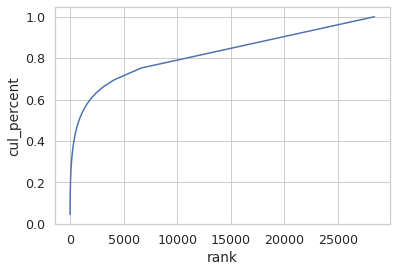

In [20]:
import seaborn as sns

sns.lineplot(x='rank', y='cul_percent', data=wc);

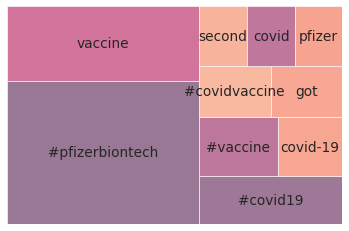

In [21]:
import squarify
import matplotlib.pyplot as plt
wc_top10 = wc[wc['rank'] <= 10]

squarify.plot(sizes=wc_top10['percent'], label=wc_top10['word'], alpha=0.6 )
plt.axis('off')
plt.show()

# BERT Model

In [22]:
!pip install transformers

## Data 적용

In [23]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

In [24]:
df.columns = ['raw_text', 'text', 'tokens']

# Define model

In [26]:
# A dependency of the preprocessing for BERT inputs
!pip install -q tensorflow-text

In [27]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import warnings

warnings.filterwarnings(action='ignore') 

In [28]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


----
BERT Test

In [29]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_word_ids', 'input_mask', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [30]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.7626289   0.9928099  -0.18611847  0.36673844  0.15233688  0.6550448
  0.9681154  -0.948627    0.00216161 -0.9877732   0.06842694 -0.97630596]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.2894631   0.34321257  0.33231482 ...  0.2130079   0.710208
  -0.05771104]
 [-0.28741983  0.31981012 -0.2301856  ...  0.584551   -0.21329626
   0.7269212 ]
 [-0.6615694   0.68876845 -0.87433046 ...  0.10877308 -0.2617321
   0.47855446]
 ...
 [-0.22561106 -0.28925565 -0.07064411 ...  0.4756602   0.8327715
   0.40025333]
 [-0.29824218 -0.27473184 -0.05450517 ...  0.48849645  1.0955355
   0.1816338 ]
 [-0.44378152  0.00930741  0.07223725 ...  0.17290096  1.1833245
   0.0789802 ]]


# Define Model

In [31]:
tf.__version__

'2.4.1'

In [32]:
!pip install -q tf-models-official

In [33]:
!pip install -q tensorflow-text

In [34]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [42]:
df['text']

0       same folks said daikon paste could treat a cyt...
1       while the world has been on the wrong side of ...
2       coronavirus sputnikv astrazeneca pfizerbiontec...
3       facts are immutable senator even when youre no...
4       explain to me again why we need a vaccine bori...
                              ...                        
8077    off for my second vaccine then work cured pfiz...
8078    when appears to be a milliondollar question th...
8079    second pfizerbiontech vaccine shot done thanks...
8080    second pfizerbiontech vaccine is officially in...
8081    midday dgci why not allow other proven vaccine...
Name: text, Length: 8082, dtype: object

In [54]:
text_test = [df['text'][0]]
text_test

['same folks said daikon paste could treat a cytokine storm pfizerbiontech httpstcoxehhimg1kf']

In [55]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[ True]], shape=(1, 1), dtype=bool)


In [63]:
print(tf.sigmoid(bert_raw_result))
print(tf.sigmoid(bert_raw_result)<0.5)

tf.Tensor([[0.5108085]], shape=(1, 1), dtype=float32)
tf.Tensor([[False]], shape=(1, 1), dtype=bool)


In [ ]:
label = []
# 1 : Positive, 0 : negative
for i, v in enumerate(df['text']):
  bert_raw_result = classifier_model(tf.constant([df['text'][i]]))
  if tf.sigmoid(bert_raw_result) > 0.5:
    label.append(1)
  else:
    label.append(0)

In [70]:
df['label'] = label
df.head(2)

,raw_text,text,tokens,label
0,Same folks said daikon paste could treat a cyt...,same folks said daikon paste could treat a cyt...,"[folks, said, daikon, paste, treat, cytokine, ...",1
1,While the world has been on the wrong side of ...,while the world has been on the wrong side of ...,"[world, wrong, history, year,, hopefully,, big...",1


In [101]:
bert_df = df[['text', 'label']]
bert_df

,text,label
0,same folks said daikon paste could treat a cyt...,1
1,while the world has been on the wrong side of ...,1
2,coronavirus sputnikv astrazeneca pfizerbiontec...,1
3,facts are immutable senator even when youre no...,1
4,explain to me again why we need a vaccine bori...,1
...,...,...
8077,off for my second vaccine then work cured pfiz...,1
8078,when appears to be a milliondollar question th...,1
8079,second pfizerbiontech vaccine shot done thanks...,1
8080,second pfizerbiontech vaccine is officially in...,1


In [103]:
bert_df.label.unique()
bert_df.label.value_counts()

1    7642
0     440
Name: label, dtype: int64

In [105]:
!pip install bert-for-tf2
!pip install sentencepiece

In [106]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

In [107]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1, Total size: 423.26MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1'.


In [110]:
# test
tokenizer.tokenize("don't be so judgmental")
tokenizer.convert_tokens_to_ids(tokenizer.tokenize("dont be so judgmental"))


In [115]:
X = df['text']

In [114]:
y = df['label']
y

0       1
1       1
2       1
3       1
4       1
       ..
8077    1
8078    1
8079    1
8080    1
8081    1
Name: label, Length: 8082, dtype: int64

In [116]:
def tokenize_reviews(text_reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(text_reviews))

tokenized_reviews = [tokenize_reviews(text) for text in X]


In [120]:
reviews_with_len = [[review, y[i], len(review)]
                 for i, review in enumerate(tokenized_reviews)]

In [122]:
import random

random.shuffle(reviews_with_len)

In [123]:
reviews_with_len.sort(key=lambda x: x[2])

In [124]:
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

In [125]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

In [126]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [127]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 12), dtype=int32, numpy=
 array([[ 2117, 13004,  1052,  8873,  6290, 26282, 10111,  2818,     0,
             0,     0,     0],
        [ 2034, 13004,  2589, 14376, 17629, 26282, 10111,  2818,     0,
             0,     0,     0],
        [ 2034, 13004,  1052,  8873,  6290, 26282, 10111,  2818,     0,
             0,     0,     0],
        [ 2034, 13004,  2589,  1052,  8873,  6290, 26282, 10111,  2818,
             0,     0,     0],
        [ 3416, 13004,  2589,  1052,  8873,  6290, 26282, 10111,  2818,
             0,     0,     0],
        [12436, 14693, 23854,  1052,  8873,  6290, 26282, 10111,  2818,
             0,     0,     0],
        [ 2117,  2915,  1999,  2849, 14376, 17629, 26282, 10111,  2818,
             0,     0,     0],
        [ 1052,  8873,  6290, 26282, 10111,  2818, 17404,  2005,  4238,
             0,     0,     0],
        [ 3416, 17404,  2589,  1052,  8873,  6290, 26282, 10111,  2818,
             0,     0,     0],
        [ 2288,  1996,  

In [130]:
import math

TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

----

In [131]:
class TEXT_MODEL(tf.keras.Model):
    
    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)
        
        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()
        
        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")
    
    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l) 
        l_1 = self.pool(l_1) 
        l_2 = self.cnn_layer2(l) 
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3) 
        
        concatenated = tf.concat([l_1, l_2, l_3], axis=-1) # (batch_size, 3 * cnn_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)
        
        return model_output

In [132]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

NB_EPOCHS = 5

text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [155]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

if OUTPUT_CLASSES == 2:
    text_model.compile(loss=loss,
                       optimizer="adam",
                       metrics=metrics)
else:
    text_model.compile(loss=loss,
                       optimizer="adam",
                       metrics=metrics)

In [156]:
hist = text_model.fit(train_data,validation_data=test_data, epochs=NB_EPOCHS)

Epoch 1/5
228/228 [==============================] - 12s 49ms/step - loss: 0.0010 - binary_accuracy: 1.0000 - val_loss: 1.3191 - val_binary_accuracy: 0.8850
Epoch 2/5
228/228 [==============================] - 11s 46ms/step - loss: 0.0021 - binary_accuracy: 0.9995 - val_loss: 1.6162 - val_binary_accuracy: 0.8975
Epoch 3/5
228/228 [==============================] - 10s 45ms/step - loss: 0.0111 - binary_accuracy: 0.9981 - val_loss: 1.2335 - val_binary_accuracy: 0.8900
Epoch 4/5
228/228 [==============================] - 11s 46ms/step - loss: 0.0065 - binary_accuracy: 0.9980 - val_loss: 1.2769 - val_binary_accuracy: 0.8800
Epoch 5/5
228/228 [==============================] - 11s 47ms/step - loss: 2.8210e-04 - binary_accuracy: 1.0000 - val_loss: 1.2897 - val_binary_accuracy: 0.8838


dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


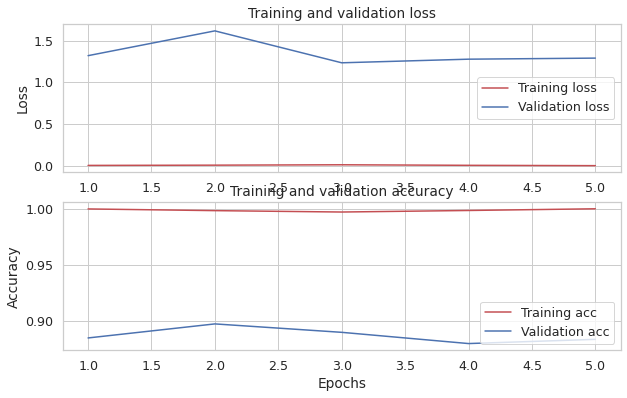

In [158]:
history_dict = hist.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [159]:
dataset_name = 'tweetdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

#  모델 테스트

In [160]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [161]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.550451
input: The movie was great!           : score: 0.563808
input: The movie was meh.             : score: 0.560254
input: The movie was okish.           : score: 0.597390
input: The movie was terrible...      : score: 0.592957

Results from the model in memory:
input: this is such an amazing movie! : score: 0.550451
input: The movie was great!           : score: 0.563808
input: The movie was meh.             : score: 0.560254
input: The movie was okish.           : score: 0.597390
input: The movie was terrible...      : score: 0.592957

